In [36]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import StandardScaler



all_df = pd.read_csv("C:/Users/ralph/OneDrive - The University of Nottingham/COMPUTER SCIENCE MSC/Machine Learning/Coursework/Assignment 2/TrainDataset2024.csv", index_col=False)
all_df.drop('ID', axis=1, inplace=True)
all_df.head()
# classification target
clf_y = all_df['pCR (outcome)']
# regression target
rgr_y = all_df['RelapseFreeSurvival (outcome)']

In [37]:
all_df.shape
X_rgr = all_df.iloc[:, 3:]
X_rgr

,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,Gene,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0,0,0,1,3,3,1,1,2,1,...,0.517172,0.375126,3.325332,0.002314,3.880772e+06,473.464852,0.000768,0.182615,0.030508,0.000758
1,1,1,0,0,3,3,1,1,2,0,...,0.444391,0.444391,3.032144,0.005612,2.372010e+06,59.459710,0.004383,0.032012,0.001006,0.003685
2,0,0,0,1,2,1,1,0,2,1,...,0.534549,0.534549,2.485848,0.006752,1.540027e+06,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,0,0,1,3,3,1,1,3,1,...,0.506185,0.506185,2.606255,0.003755,6.936741e+06,46.859265,0.005424,0.013707,0.000178,0.004543
4,1,0,0,0,2,1,1,0,2,1,...,0.462282,0.462282,2.809279,0.006521,1.265399e+06,39.621023,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,0,1,0,3,2,1,1,4,0,...,0.476493,0.476493,2.453583,0.003229,2.327038e+06,18.562377,0.013766,0.018042,0.000288,0.012257
396,0,0,0,1,3,3,1,0,2,0,...,0.418382,0.418382,2.995603,0.004243,1.005061e+06,156.627179,0.002228,0.136015,0.022148,0.002098
397,0,0,0,1,2,1,1,0,2,0,...,0.527779,0.527778,1.500000,0.003728,2.132007e+05,0.996746,0.252582,0.007380,0.000037,0.231059
398,1,0,0,0,3,3,1,1,3,0,...,0.313693,0.313693,3.573557,0.001112,2.008034e+07,204.864200,0.001372,0.054063,0.003697,0.001368


In [38]:
indices_to_remove = set()

for i in range(X_rgr.shape[1]):
    if X_rgr.iloc[:, i].dtype == np.int64:
        indices_to_remove.update(X_rgr[X_rgr.iloc[:, i] == 999].index)
    else:
        median = X_rgr.iloc[:, i].median()
        X_rgr.iloc[:, i] = X_rgr.iloc[:, i].replace(999, median)

# Remove duplicates from indices_to_remove
indices_to_remove = list(indices_to_remove)

# Remove the rows from X_rgr and rfs
X_rgr = X_rgr.drop(indices_to_remove)
rgr_y = rgr_y.drop(indices_to_remove)

print(X_rgr.shape)
print(rgr_y.shape)

(310, 117)
(310,)


### OUTLIER OPTION A: Ralph's Implementation

In [39]:
outlier_indices = set()
for column in X_rgr.columns:
    Q1 = X_rgr[column].quantile(0.25)
    Q3 = X_rgr[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 7 * IQR
    upper_bound = Q3 + 7 * IQR

    outliers = X_rgr[(X_rgr[column] < lower_bound) | (X_rgr[column] > upper_bound)].index
    outlier_indices.update(outliers)

    outliers_sum = ((X_rgr[column] < lower_bound) | (X_rgr[column] > upper_bound)).sum()
    print(f'{column}: {outliers_sum} outliers')

outlier_indices = list(outlier_indices)

X_rgr = X_rgr.drop(index=outlier_indices)
rgr_y = rgr_y.drop(index=outlier_indices)
clf_y = clf_y.drop(index=outlier_indices)

ER: 0 outliers
PgR: 0 outliers
HER2: 0 outliers
TrippleNegative: 0 outliers
ChemoGrade: 0 outliers
Proliferation: 0 outliers
HistologyType: 49 outliers
LNStatus: 0 outliers
TumourStage: 0 outliers
Gene: 0 outliers
original_shape_Elongation: 0 outliers
original_shape_Flatness: 0 outliers
original_shape_LeastAxisLength: 0 outliers
original_shape_MajorAxisLength: 1 outliers
original_shape_Maximum2DDiameterColumn: 0 outliers
original_shape_Maximum2DDiameterRow: 1 outliers
original_shape_Maximum2DDiameterSlice: 0 outliers
original_shape_Maximum3DDiameter: 0 outliers
original_shape_MeshVolume: 2 outliers
original_shape_MinorAxisLength: 0 outliers
original_shape_Sphericity: 0 outliers
original_shape_SurfaceArea: 3 outliers
original_shape_SurfaceVolumeRatio: 0 outliers
original_shape_VoxelVolume: 2 outliers
original_firstorder_10Percentile: 0 outliers
original_firstorder_90Percentile: 0 outliers
original_firstorder_Energy: 3 outliers
original_firstorder_Entropy: 0 outliers
original_firstorder_

## OUTLIER OPTION B: Tomas' Implementation

In [ ]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

def mad_based_outlier(points, threshold=3.5):
    points = np.array(points)
    if len(points.shape) == 1:
        points = points[:, None]
    median_y = np.median(points)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in points])
    # Small constant added to avoid division by zero
    modified_z_scores = [0.6745 * (y - median_y) / (median_absolute_deviation_y + 1e-6) for y in points]

    return np.abs(modified_z_scores) > threshold

def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if abs(val - mean)/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutliers(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = func(x)
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(20, 15)

def removeOutliers(data):
    # Remove outliers from the dataframe
    for column in data.columns:
        outliers = outlierVote(all_df[column])
        # Calculate Non-Outlier Maximum using the outliers list
        non_outlier_max = all_df.loc[~np.array(outliers), column].max()
        # Replace outliers with the maximum non-outlier value
        data.loc[outliers, column] = non_outlier_max

removeOutliers(all_df)
# Verify the changes
all_df.head()

# Assign features to X
X = all_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)

In [40]:
X_rgr.shape

(218, 117)

In [41]:
# Normalise X_rgr using sklearn's StandardScaler
scaler = StandardScaler()
X_rgr_normalized = pd.DataFrame(scaler.fit_transform(X_rgr), columns=X_rgr.columns)


In [ ]:
# Create manifold of MRI scan data (columns 11 onwards)

tsne = TSNE(n_components=2, random_state=42)
# isomap = Isomap(n_components=)
X_tsne_mri = tsne.fit_transform(X_rgr.iloc[:,11:])

# plot manifold
plt.scatter(X_tsne_mri[:, -2], X_tsne_mri[:, -1], c=clf_y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

# combine columns 0-10 with the manifold
X_tsne_mri = np.c_[X_rgr.iloc[:,0:11], X_tsne_mri]

## MANIFOLD ON GROUPS OF MRI DATA

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


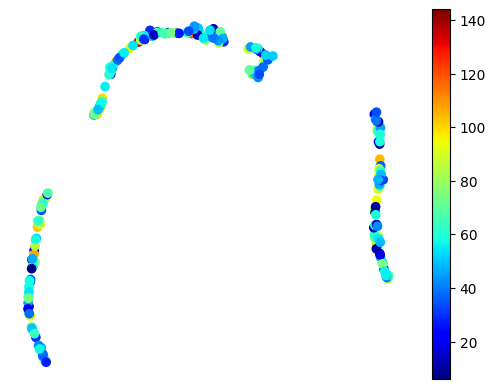

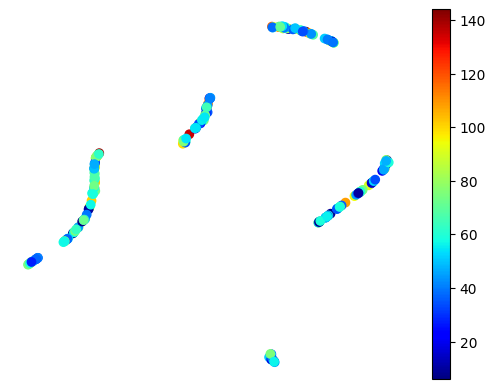

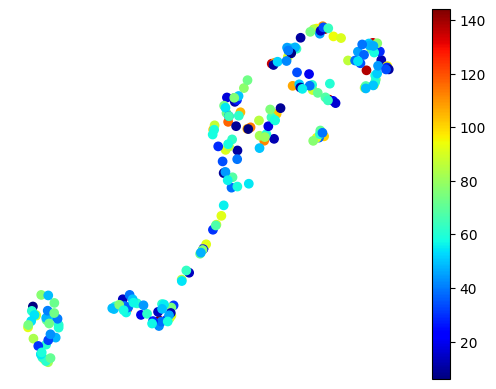

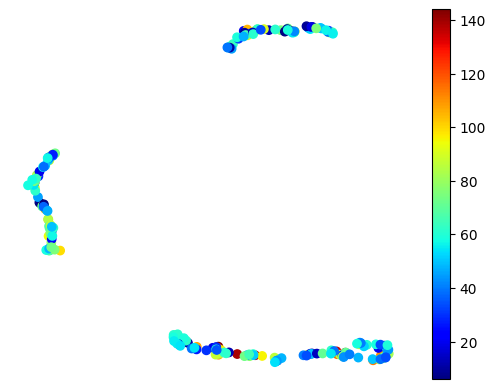

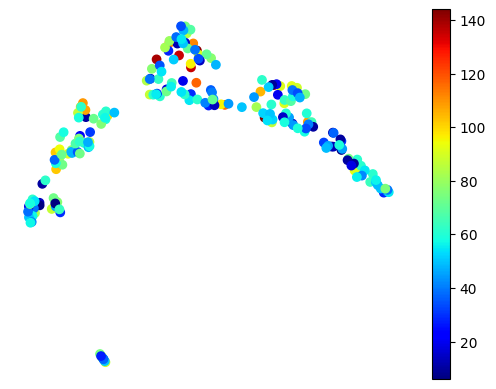

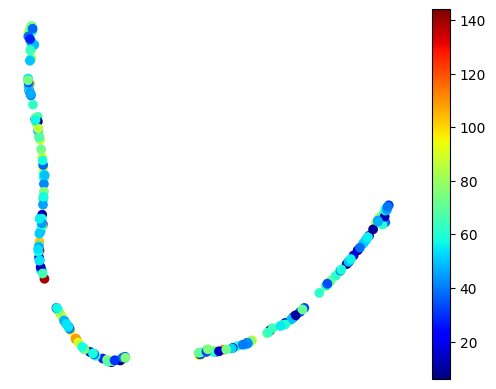

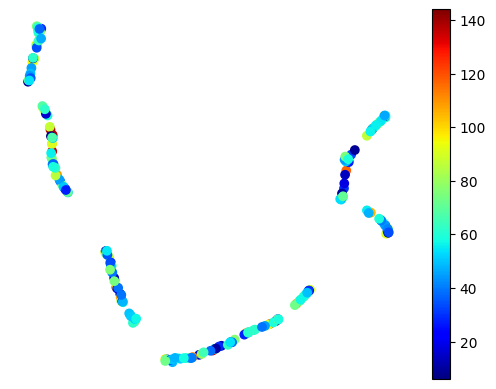

In [42]:
import umap.umap_ as umap

# Create manifold of MRI scan data (columns 11 onwards)

# Create UMAP manifold of MRI scan data (columns 11 onwards)
umap_model = umap.UMAP(n_components=2, random_state=42)

# SELECT columns that start with "original_shape"
X_rgr_shape = X_rgr.filter(regex='original_shape', axis=1)
X_rgr_first_order = X_rgr.filter(regex='original_firstorder', axis=1)
X_rgr_glcm = X_rgr.filter(regex='original_glcm', axis=1)
X_rgr_gldm = X_rgr.filter(regex='original_gldm', axis=1)
X_rgr_glrlm = X_rgr.filter(regex='original_glrlm', axis=1) 
X_rgr_glszm = X_rgr.filter(regex='original_glszm', axis=1)
X_rgr_ngtdm = X_rgr.filter(regex='original_ngtdm', axis=1)

# Add the features into an iterable of dataframes
X_rgr_mris = [X_rgr_shape, X_rgr_first_order, X_rgr_glcm, X_rgr_gldm, X_rgr_glrlm, X_rgr_glszm, X_rgr_ngtdm]

X_rgr_combined = X_rgr.iloc[:, 0:11]

#plot manifold for each feature group
for X_rgr_mri in X_rgr_mris:
    X_umap_mri = umap_model.fit_transform(X_rgr_mri)
    plt.scatter(X_umap_mri[:, 0], X_umap_mri[:, 1], c=rgr_y, cmap="jet")
    plt.axis('off')
    plt.colorbar()
    plt.show() 
    X_rgr_combined = np.c_[X_rgr_combined, X_umap_mri]

# # combine columns 0-10 with the manifold
# X_umap_mri = np.c_[X_rgr.iloc[:, 0:11], X_umap_mri]

In [43]:
X_rgr_combined.shape

(218, 25)

## Nested K-Fold Validation: Number of Dimensions
#### Not much better

In [47]:
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1)
svr_outer = SVR(C=3, gamma=0.1, kernel='rbf')
svr_inner = SVR(C=3, gamma=0.1, kernel='rbf')

n_dimensions_range = 10 # Set hyperparameter range of values
kf_inner = KFold(n_splits=n_dimensions_range, shuffle=True, random_state=1) # Create kfold for inner loop

best_n_dimensions_list = []   # Best degrees resulting from inner fold
best_val_mae_list = []  # For inner fold
test_mae_list = [] # For outer fold

for train_index, test_index in kf.split(X_rgr_combined):
    X_train, X_test = X_umap_mri[train_index],X_umap_mri[test_index]
    y_train, y_test = rgr_y.iloc[train_index], rgr_y.iloc[test_index]

    best_n_dimensions = 1
    best_val_mae = np.inf

    degree = 1
    for train_index_inner, val_index in kf_inner.split(X_train):
        X_train_inner, X_val = X_train[train_index_inner],  X_train[val_index]
        y_train_inner, y_val = y_train.iloc[train_index_inner],  y_train.iloc[val_index]

        # train model with x_train_inner and y_train_inner with n dimensions
        umap_inner = umap.UMAP(n_components=degree, random_state=42)

        # Create the pure and interaction terms of degree n
        X_umap_train_inner = umap_inner.fit_transform(X_train_inner)
        X_umap_train_inner = np.c_[X_train_inner, X_umap_train_inner]
        X_umap_val = umap_inner.fit_transform(X_val)
        X_umap_val = np.c_[X_val, X_umap_val]

        svr_inner.fit(X_umap_train_inner, y_train_inner)

        # validate model on validation data and get MAE
        y_pred_inner = svr_inner.predict(X_umap_val)
        mae = mean_absolute_error(y_val, y_pred_inner)
        print(f"Degree {degree} Validation MAE: {mae:.4}", end=" ---- ")

        # if MAE is best so far, save degree and MAE
        if mae < best_val_mae:
            best_val_mae = mae
            best_degree = degree

        degree += 1
    
    best_n_dimensions_list.append(best_degree)
    best_val_mae_list.append(best_val_mae)

    umap_outer = umap.UMAP(n_components=best_degree, random_state=42)
    X_train_umap = umap_outer.fit_transform(X_train)
    X_train_umap = np.c_[X_train, X_train_umap]
    X_test_umap = umap_outer.fit_transform(X_test)
    X_test_umap = np.c_[X_test, X_test_umap]
    
    svr_outer.fit(X_train_umap, y_train)

    y_pred_test = svr_outer.predict(X_test_umap)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mae_list.append(test_mae)

print("\nSummary of outer folds:")
for i in range(num_splits):
    print(f"Fold {i+1}: Best Degree of {best_n_dimensions_list[i]}, Validation MAE = {best_val_mae_list[i]:.4f}, Test MAE = {test_mae_list[i]:.4f}")

print(f"\nAverage Test MAE: {np.mean(test_mae_list):.4f}")


c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 1 Validation MAE: 23.91 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 2 Validation MAE: 29.12 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 3 Validation MAE: 23.96 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 4 Validation MAE: 18.3 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 5 Validation MAE: 24.71 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 6 Validation MAE: 17.18 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 7 Validation MAE: 16.45 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 8 Validation MAE: 23.44 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 9 Validation MAE: 23.7 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 10 Validation MAE: 16.3 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 1 Validation MAE: 29.77 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 2 Validation MAE: 23.34 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 3 Validation MAE: 19.6 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 4 Validation MAE: 19.93 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 5 Validation MAE: 33.04 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 6 Validation MAE: 17.33 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 7 Validation MAE: 20.46 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 8 Validation MAE: 22.06 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 9 Validation MAE: 28.26 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 10 Validation MAE: 20.92 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 1 Validation MAE: 30.12 ---- Degree 2 Validation MAE: 22.79 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 3 Validation MAE: 20.02 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 4 Validation MAE: 18.92 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 5 Validation MAE: 27.05 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 6 Validation MAE: 20.86 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 7 Validation MAE: 24.31 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 8 Validation MAE: 22.22 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 9 Validation MAE: 28.96 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 10 Validation MAE: 20.09 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 1 Validation MAE: 27.05 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 2 Validation MAE: 24.72 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 3 Validation MAE: 24.68 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 4 Validation MAE: 21.48 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 5 Validation MAE: 28.38 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 6 Validation MAE: 18.17 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 7 Validation MAE: 14.06 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 8 Validation MAE: 18.59 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 9 Validation MAE: 28.45 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 10 Validation MAE: 19.06 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 1 Validation MAE: 25.97 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 2 Validation MAE: 17.1 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 3 Validation MAE: 31.33 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 4 Validation MAE: 18.98 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 5 Validation MAE: 21.39 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 6 Validation MAE: 20.87 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 7 Validation MAE: 18.39 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 8 Validation MAE: 21.83 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 9 Validation MAE: 26.42 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 10 Validation MAE: 17.78 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Summary of outer folds:
Fold 1: Best Degree of 10, Validation MAE = 16.3048, Test MAE = 26.6677
Fold 2: Best Degree of 6, Validation MAE = 17.3251, Test MAE = 19.9172
Fold 3: Best Degree of 4, Validation MAE = 18.9205, Test MAE = 18.7514
Fold 4: Best Degree of 7, Validation MAE = 14.0613, Test MAE = 23.4689
Fold 5: Best Degree of 2, Validation MAE = 17.0951, Test MAE = 24.3939

Average Test MAE: 22.6398


## Nested K-Fold Validation: Number of Neighbours

In [48]:
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1)
svr_outer = SVR(C=10, gamma=0.01, kernel='rbf')
svr_inner = SVR(C=10, gamma=0.01, kernel='rbf')

n_neighbours_range= np.linspace(5, 30, 6) # Set hyperparameter range of values
kf_inner = KFold(n_splits=len(n_neighbours_range), shuffle=True, random_state=1) # Create kfold for inner loop

best_n_neighbours_list = []   # Best n_neighbours resulting from inner fold
best_val_mae_list = []  # For inner fold
test_mae_list = [] # For outer fold

dimension = 2
for train_index, test_index in kf.split(X_umap_mri):
    X_train, X_test = X_umap_mri[train_index],X_umap_mri[test_index]
    y_train, y_test = rgr_y.iloc[train_index], rgr_y.iloc[test_index]

    best_n_neighbours = 1
    best_val_mae = np.inf

    index = 0
    for train_index_inner, val_index in kf_inner.split(X_train):
        n_neighbours = n_neighbours_range[index]
        X_train_inner, X_val = X_train[train_index_inner],  X_train[val_index]
        y_train_inner, y_val = y_train.iloc[train_index_inner],  y_train.iloc[val_index]

        # train model with x_train_inner and y_train_inner with n neighbours
        umap_inner = umap.UMAP(n_components=dimension, random_state=42, n_neighbors=int(n_neighbours))

        # Create the pure and interaction terms of n_neighbours n
        X_umap_train_inner = umap_inner.fit_transform(X_train_inner)
        X_umap_train_inner = np.c_[X_train_inner, X_umap_train_inner]
        X_umap_val = umap_inner.fit_transform(X_val)
        X_umap_val = np.c_[X_val, X_umap_val]

        svr_inner.fit(X_umap_train_inner, y_train_inner)

        # validate model on validation data and get MAE
        y_pred_inner = svr_inner.predict(X_umap_val)
        mae = mean_absolute_error(y_val, y_pred_inner)
        print(f"n_neighbours {n_neighbours} Validation MAE: {mae:.4}", end=" ---- ")

        # if MAE is best so far, save n_neighbours and MAE
        if mae < best_val_mae:
            best_val_mae = mae
            best_n_neighbours = n_neighbours

        n_neighbours += 1
    
    best_n_neighbours_list.append(best_n_neighbours)
    best_val_mae_list.append(best_val_mae)

    umap_outer = umap.UMAP(n_components=dimension, random_state=42, n_neighbors=int(best_n_neighbours))
    X_train_umap = umap_outer.fit_transform(X_train)
    X_train_umap = np.c_[X_train, X_train_umap]
    X_test_umap = umap_outer.fit_transform(X_test)
    X_test_umap = np.c_[X_test, X_test_umap]
    
    svr_outer.fit(X_train_umap, y_train)

    y_pred_test = svr_outer.predict(X_test_umap)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mae_list.append(test_mae)

print("\nSummary of outer folds:")
for i in range(num_splits):
    print(f"Fold {i+1}: Best n_neighbours of {best_n_neighbours_list[i]}, Validation MAE = {best_val_mae_list[i]:.4f}, Test MAE = {test_mae_list[i]:.4f}")

print(f"\nAverage Test MAE: {np.mean(test_mae_list):.4f}")


c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 26.96 ---- n_neighbours 5.0 Validation MAE: 24.89 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 22.64 ---- n_neighbours 5.0 Validation MAE: 17.34 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 24.97 ---- n_neighbours 5.0 Validation MAE: 16.27 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 28.09 ---- n_neighbours 5.0 Validation MAE: 16.53 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 30.23 ---- n_neighbours 5.0 Validation MAE: 19.14 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 24.85 ---- n_neighbours 5.0 Validation MAE: 22.22 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 27.71 ---- n_neighbours 5.0 Validation MAE: 19.35 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 25.44 ---- n_neighbours 5.0 Validation MAE: 18.63 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 27.35 ---- n_neighbours 5.0 Validation MAE: 21.65 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 26.35 ---- n_neighbours 5.0 Validation MAE: 21.36 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 26.36 ---- n_neighbours 5.0 Validation MAE: 16.51 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 21.76 ---- n_neighbours 5.0 Validation MAE: 20.03 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 22.23 ---- n_neighbours 5.0 Validation MAE: 24.62 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 20.95 ---- n_neighbours 5.0 Validation MAE: 19.29 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 24.68 ---- n_neighbours 5.0 Validation MAE: 19.0 ---- 
Summary of outer folds:
Fold 1: Best n_neighbours of 5.0, Validation MAE = 16.2656, Test MAE = 25.6612
Fold 2: Best n_neighbours of 5.0, Validation MAE = 16.5297, Test MAE = 19.4394
Fold 3: Best n_neighbours of 5.0, Validation MAE = 18.6283, Test MAE = 19.1733
Fold 4: Best n_neighbours of 5.0, Validation MAE = 16.5107, Test MAE = 23.2795
Fold 5: Best n_neighbours of 5.0, Validation MAE = 19.0023, Test MAE = 24.1825

Average Test MAE: 22.3472


c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
